In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd

In [2]:
author_data = {'period': [7836, 53655, 115615, 161926, 38177, 46371, 2699],
               'comma': [13112, 102383, 184541, 340479, 105101, 58367, 5675],
               'others': [6026, 42413, 59226, 62754, 12670, 14299, 1046]}
author_data = pd.DataFrame(author_data, columns=['period', 'comma', 'others'],
                           index=['Rousseau', 'Chateaubriand', 'Hugo', 'Zola',\
                                  'Proust', 'Giraudoux', 'Aloz'])
author_data

,period,comma,others
Rousseau,7836,13112,6026
Chateaubriand,53655,102383,42413
Hugo,115615,184541,59226
Zola,161926,340479,62754
Proust,38177,105101,12670
Giraudoux,46371,58367,14299
Aloz,2699,5675,1046


In [16]:
# corranal.py: Python Correspondence Analysis
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd
from numpy.linalg import svd

def _coordinates_df(array_x1, array_x2, rows, cols):
    """Create pandas DataFrame with coordinates in rows and columns.
        
    Args:
      array_x1: numpy array, coordinates in rows.
      array_x2: numpy array, coordinates in columns.
      rows: numpy array, row group name.
      cols: numpy array, column group name.
        
    Returns:
      coord_df: pandas DataFrame with columns {'x_1',..., 'x_K', 'point', 'coord'}:
        x_k, k=1,...,K: K-dimensional coordinates.
        point: row and column points for labeling.
        coord: {'row', 'col'}, indicates row point or column point.
    """
    row_df = pd.DataFrame(
        array_x1, columns=['x' +  str(i) for i in (np.arange(array_x1.shape[1]) + 1)])
    row_df['point'] = rows
    row_df['coord'] = 'row'
    col_df = pd.DataFrame(
        array_x2, columns=['x' +  str(i) for i in (np.arange(array_x2.shape[1]) + 1)])
    col_df['point'] = cols
    col_df['coord'] = 'col'         
    coord_df = pd.concat([row_df, col_df], ignore_index=True)
    return coord_df

def ca(df, option='symmetric'):
    """Correspondence Analysis.
    
    This method performs generalized singular value decomposition (SVD) for
    correspondence matrix and computes principal and standard coordinates for
    rows and columns.
    
    ### Usage
    
    ```
    ca_output = ca(author_data, option='symmetric')
    coord_df = ca_output['coordinates']
    inertia_prop = ca_output['inertia_proportion']
    ```
    
    Args:
      df: pandas DataFrame, with row and column names.
      option: string, in one of the following three:
        'symmetric': symmetric map with 
          - rows and columns in principal coordinates.
        'rowprincipal': asymmetric map with 
          - rows in principal coordinates and 
          - columns in standard coordinates.  
        'colprincipal': asymmetric map with 
          - rows in standard coordinates and 
          - columns in principal coordinates.
    
    Returns:
      d : dict, information dict.
        * d['coordinates']: pandas DataFrame, contains coordinates, row and column points. 
        * d['inertia_proportion']: numpy array, contains proportions of total inertia explained 
            in coordinate dimensions.
    
    Raises:
      TypeError: The input is not a pandas DataFrame
      ValueError: Numpy array contains missing values.
      TypeError: Numpy array contains data types other than numeric.
      ValueError: Option only includes {"symmetric", "rowprincipal", "colprincipal"}.
    """

    if isinstance(df, pd.DataFrame) is not True:
        raise TypeError('The input is not a pandas DataFrame.')  
    rows = np.array(df.index)
    cols = np.array(df.columns)
    np_data = np.array(df.values)      
    if np.isnan(np_data).any():
        raise ValueError('Numpy array contains missing values.')
    if np.issubdtype(np_data.dtype, np.number) is not True:
        raise TypeError('Numpy array contains data types other than numeric.')

    p_corrmat = np_data / np_data.sum()
    r_profile = p_corrmat.sum(axis=1).reshape(p_corrmat.shape[0], 1)
    c_profile = p_corrmat.sum(axis=0).reshape(p_corrmat.shape[1], 1)
    Dr_invsqrt = np.diag(np.power(r_profile, -1/2).T[0])
    Dc_invsqrt = np.diag(np.power(c_profile, -1/2).T[0])
    ker_mat = np.subtract(p_corrmat, np.dot(r_profile, c_profile.T))
    left_mat = Dr_invsqrt
    right_mat = Dc_invsqrt
    weighted_lse = left_mat.dot(ker_mat).dot(right_mat)
    U, sv, Vt = svd(weighted_lse, full_matrices=False)
    V = Vt.T
    SV = np.diag(sv)
    inertia = np.power(sv, 2)
    
    if option == 'symmetric':
        # Symmetric map with pricipal coordinates for rows and columns.
        F = Dr_invsqrt.dot(U).dot(SV)
        G = Dc_invsqrt.dot(V).dot(SV)
        coordinates = _coordinates_df(F, G, rows, cols)
    elif option == 'rowprincipal':
        # Asymmetric map with principal coordinates for rows and standard ones for columns.
        F = Dr_invsqrt.dot(U).dot(SV)
        Gam = Dc_invsqrt.dot(V)
        coordinates = _coordinates_df(F, Gam, rows, cols)
    elif option == 'colprincipal':
        # Asymmetric map with standard coordinates for rows and principal ones for columns.
        Phi = Dr_invsqrt.dot(U)
        G = Dc_invsqrt.dot(V).dot(SV)
        coordinates = _coordinates_df(Phi, G, rows, cols)
    else:
        raise ValueError(
            'Option only includes {"symmetric", "rowprincipal", "colprincipal"}.')
    
    inertia_proportion = (inertia / inertia.sum())

    d = {'coordinates': coordinates, 
         'inertia_proportion': inertia_proportion}
    
    return d

In [20]:
ca_output = ca(author_data, option='symmetric')

coord_df = ca_output['coordinates']
inertia_prop = ca_output['inertia_proportion']

In [21]:
coord_df

,x1,x2,x3,point,coord
0,0.240510,0.074052,1.439806e-18,Rousseau,row
1,0.190265,0.107088,2.009690e-17,Chateaubriand,row
2,0.103926,-0.029745,-4.315813e-17,Hugo,row
3,-0.091241,0.001672,-2.369237e-17,Zola,row
4,-0.223706,0.063149,1.648296e-17,Proust,row
5,0.048025,-0.196308,4.417461e-17,Giraudoux,row
6,-0.091230,0.001666,6.454161e-17,Aloz,row
7,0.048830,-0.111209,3.102594e-17,period,col
8,-0.097101,0.036552,3.102594e-17,comma,col
9,0.291297,0.089761,3.102594e-17,others,col


In [19]:
inertia_prop

array([  7.62192262e-01,   2.37807738e-01,   4.12891943e-32])

In [ ]:
from __future__ import division
from __future__ import print_function

import numpy as np
import scipy as sp 
import pandas as pd
from numpy.linalg import svd

class CA(object):
    """Correspondence analysis (CA).
    
    ### Usage

    ```python
    corranal = CA(aggregate_cnt)
    corranal.fit()
    coord_df = corranal.get_coordinates()
    inertia_prop = corranal.score_inertia()
    ```

    @@__init__
    
    @@fit
    @@get_coordinates
    @@score_inertia
    """

    def __init__(self, df):
        """Create a new Correspondence Analysis.
        
        Args:
          df: pandas DataFrame, with row and column names.
          
        Raises:
          TypeError: The input is not a pandas DataFrame
          ValueError: Numpy array contains missing values.
          TypeError: Numpy array contains data types other than numeric.
        """
        if isinstance(df, pd.DataFrame) is not True:
            raise TypeError('The input is not a Pandas DataFrame.')  
        self._rows = np.array(df.index)
        self._cols = np.array(df.columns)
        self._np_data = np.array(df.values)      
        if np.isnan(self._np_data).any():
            raise ValueError('Numpy array contains missing values.')
        if np.issubdtype(self._np_data.dtype, np.number) is not True:
            raise TypeError('Numpy array contains data types other than numeric.')

    def fit(self):
        """Compute Correspondence Analysis.
        
        This method performs generalized singular value decomposition (SVD) for
        correspondence matrix and computes principal and standard coordinates for
        rows and columns.
        """     
        p_corrmat = self._np_data / self._np_data.sum()
        r_profile = p_corrmat.sum(axis=1).reshape(p_corrmat.shape[0], 1)
        c_profile = p_corrmat.sum(axis=0).reshape(p_corrmat.shape[1], 1)
        Dr_invsqrt = np.diag(np.power(r_profile, -1/2).T[0])
        Dc_invsqrt = np.diag(np.power(c_profile, -1/2).T[0])
        ker_mat = np.subtract(p_corrmat, np.dot(r_profile, c_profile.T))
        left_mat = Dr_invsqrt
        right_mat = Dc_invsqrt
        weighted_lse = left_mat.dot(ker_mat).dot(right_mat)
        U, sv, Vt = svd(weighted_lse, full_matrices=False)
        self._Dr_invsqrt = Dr_invsqrt
        self._Dc_invsqrt = Dc_invsqrt
        self._U = U
        self._V = Vt.T
        self._SV = np.diag(sv)
        self._inertia = np.power(sv, 2)
        # Pricipal coordinates for rows and columns.
        self._F = self._Dr_invsqrt.dot(self._U).dot(self._SV)
        self._G = self._Dc_invsqrt.dot(self._V).dot(self._SV)
        # Standard coordinates for rows and columns.
        self._Phi = self._Dr_invsqrt.dot(self._U)
        self._Gam = self._Dc_invsqrt.dot(self._V)
        return self
    
    def _coordinates_df(self, array_x1, array_x2):
        """Create pandas DataFrame with coordinates in rows and columns.
        
        Args:
          array_x1: numpy array, coordinates in rows.
          array_x2: numpy array, coordinates in columns.
        
        Returns:
          coord_df: A Pandas DataFrame with columns 
            {'x_1',..., 'x_K', 'point', 'coord'}:
            - x_k, k=1,...,K: K-dimensional coordinates.
            - point: row and column points for labeling.
            - coord: {'row', 'col'}, indicates row point or column point.
        """
        row_df = pd.DataFrame(
            array_x1, columns=['x' +  str(i) for i in (np.arange(array_x1.shape[1]) + 1)])
        row_df['point'] = self._rows
        row_df['coord'] = 'row'
        col_df = pd.DataFrame(
            array_x2, columns=['x' +  str(i) for i in (np.arange(array_x2.shape[1]) + 1)])
        col_df['point'] = self._cols
        col_df['coord'] = 'col'         
        coord_df = pd.concat([row_df, col_df], ignore_index=True)
        return coord_df
    
    def get_coordinates(self, option='symmetric'):
        """Take coordinates in rows and columns for symmetric or assymetric map.
        
        - For symmetric map, we can catch row-to-row and column-to-column 
        association (maybe not row-to-column association); 
        - For asymmetric map, we can further catch row-to-column association.
        
        Args:
          option: string, in one of the following three:
            'symmetric': symmetric map with 
              - rows and columns in principal coordinates.
            'rowprincipal': asymmetric map with 
              - rows in principal coordinates and 
              - columns in standard coordinates.  
            'colprincipal': asymmetric map with 
              - rows in standard coordinates and 
              - columns in principal coordinates.
        
        Returns:
          Pandas DataFrame, contains coordinates, row and column points.
        
        Raises:
          ValueError: Option only includes {"symmetric", "rowprincipal", "colprincipal"}.
        """     
        if option == 'symmetric':
            # Symmetric map
            return self._coordinates_df(self._F, self._G)
        elif option == 'rowprincipal':
            # Row principal asymmetric map
            return self._coordinates_df(self._F, self._Gam)
        elif option == 'colprincipal':
            # Column principal asymmetric map
            return self._coordinates_df(self._Phi, self._G)
        else:
            raise ValueError(
                'Option only includes {"symmetric", "rowprincipal", "colprincipal"}.')

    @property
    def score_inertia(self):
        """Score inertia.
        
        Returns:
          numpy array, contains proportions of total inertia explained 
            in coordinate dimensions.
        """
        inertia = self._inertia
        self._inertia_prop = (inertia / inertia.sum()).cumsum()
        return self._inertia_prop

In [ ]:
# corranal = CorrAnal(data)
# corranal.ca()
# inertia_prop = corranal.inertia_proportion
# coord_df = corranal.coordinates()
# print(inertia_prop)
# coord_df

In [22]:
%load_ext rpy2.ipython

In [24]:
%%R
library(ggplot2)
library(scales)
library(dplyr)
library(data.table)
library(grid)
library(gridExtra)

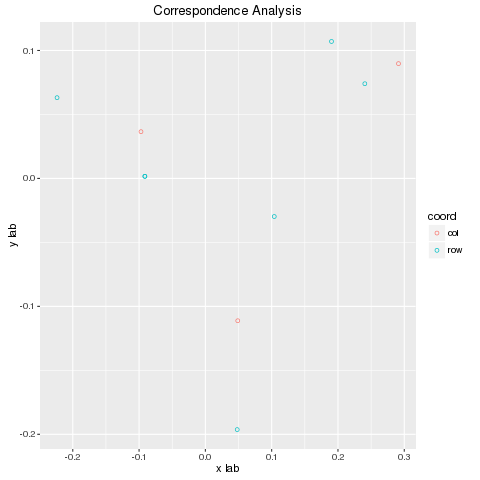

In [25]:
%%R -i coord_df,inertia_prop
ggplot(coord_df, aes(x1, x2)) + 
  geom_point(aes(colour=coord), shape=1) +
  labs(title='Correspondence Analysis', x='x lab', y='y lab')

---
The following are for implementation scratch.

In [ ]:
np.arange(7)

In [ ]:
print(isinstance(data, pd.DataFrame))

In [ ]:
rows = np.array(data.index)
cols = np.array(data.columns)
np_data = np.array(data.values)

print('rows:', rows)
print('cols:', cols)
print('np_data:\n', np_data)

In [ ]:
np.isnan(np_data).any()

In [ ]:
print(np_data.dtype)
np.issubdtype(np_data.dtype, np.number)

In [ ]:
p_corrmat = np_data / np_data.sum()
print(p_corrmat)
print(p_corrmat.shape)

In [ ]:
r_profile = p_corrmat.sum(axis=1).reshape(p_corrmat.shape[0], 1)
c_profile = p_corrmat.sum(axis=0).reshape(p_corrmat.shape[1], 1)
print('r_profile:\n', r_profile)
print('c_profile:\n', c_profile)

In [ ]:
# Dr_invsqrt = np.diag(np.power(p_corrmat.sum(axis=1), -1/2))
# Dc_invsqrt = np.diag(np.power(p_corrmat.sum(axis=0), -1/2))
# print(Dr_invsqrt)
# print(Dc_invsqrt)

In [ ]:
%time Dr_invsqrt = np.diag(np.power(r_profile, -1/2).T[0])
%time Dc_invsqrt = np.diag(np.power(c_profile, -1/2).T[0])
print('Dr_invsqrt:\n', Dr_invsqrt)
print('Dc_invsqrt:\n', Dc_invsqrt)

In [ ]:
a = np.array([1, 2, 3, 4]).reshape(2, 2)
b = np.array([1, 3, 4, 5]).reshape(2, 2)
print('a:\n', a)
print('b:\n', b)
print('a*b*a:\n', a.dot(b).dot(a))

In [ ]:
# %time print(p_corrmat - np.dot(r_profile, c_profile.T))
%time print(np.subtract(p_corrmat, np.dot(r_profile, c_profile.T)))

In [ ]:
ker_mat = np.subtract(p_corrmat, np.dot(r_profile, c_profile.T))
left_mat = Dr_invsqrt
right_mat = Dc_invsqrt
weighted_lse = left_mat.dot(ker_mat).dot(right_mat)
print(weighted_lse)

In [ ]:
U, sv, Vt = svd(weighted_lse, full_matrices=False)
V = Vt.T
SV = np.diag(sv)
inertia = np.power(sv, 2)

print('Shape of U:', U.shape)
print('U:\n', U)
print('Shape of sv:', sv.shape)
print('sv:\n', sv)
print('SV:\n', SV)
print('V:\n', V)
print('Inertia:', inertia)

In [ ]:
(inertia / inertia.sum()).cumsum()

In [ ]:
# Check matrix orthogonality
print('U1*U1:', U[:, 0].dot(U[:, 0]))
print('U0*U2:', U[:, 0].dot(U[:, 1]))
print('V1*V1:', V[:, 0].dot(V[:, 0]))
print('V1*V2:', V[:, 0].dot(V[:, 1]))

In [ ]:
# Symmetric map
F = Dr_invsqrt.dot(U).dot(SV)
G = Dc_invsqrt.dot(V).dot(SV)

print('F shape:', F.shape)
print('F:\n', F)
print('G shape:', G.shape)
print('G:\n', G)

In [ ]:
def coordinates_df(df1, df2):
    row_df = pd.DataFrame(
        df1, columns=['x' +  str(i) for i in (np.arange(df1.shape[1]) + 1)])
    row_df['coord'] = 'row'
    col_df = pd.DataFrame(
        df2, columns=['x' +  str(i) for i in (np.arange(df2.shape[1]) + 1)])
    col_df['coord'] = 'col'
    coord_df = pd.concat([row_df, col_df])  
    return coord_df

In [ ]:
coordinates_df(F, G)

In [ ]:
# Row principal asymmetric map
F = Dr_invsqrt.dot(U).dot(SV)
Gam = Dc_invsqrt.dot(V)

print('F shape:', F.shape)
print('Gamma shape:', Gam.shape)

In [ ]:
# Column principal asymmetric map
Phi = Dr_invsqrt.dot(U)
G = Dc_invsqrt.dot(V).dot(SV)

print('Phi shape:', Phi.shape)
print('G shape:', G.shape)

In [ ]:
# Check matrix relationship
print('F vs. inertia:', np.allclose(F.T.dot(np.diag(r_profile.T[0])).dot(F), np.power(SV, 2)))
print('G vs. inertia:', np.allclose(G.T.dot(np.diag(c_profile.T[0])).dot(G), np.power(SV, 2)))
print('F vs. inertia:', np.allclose(Phi.T.dot(np.diag(r_profile.T[0])).dot(Phi), np.eye(3)))
print('G vs. inertia:', np.allclose(Gam.T.dot(np.diag(c_profile.T[0])).dot(Gam), np.eye(3)))